# Spam Dataset Classification

In [1]:
import pandas as pd
from pathlib import Path
import importlib
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
import functions
importlib.reload(functions)
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


data_path = Path("DATASET") / "spambase.data"
df = pd.read_csv(data_path, header=None)
df.columns = [f"col_{i}" for i in range(df.shape[1])]
display(df.head())

print(df.shape)      # (n_lignes, n_colonnes)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_48,col_49,col_50,col_51,col_52,col_53,col_54,col_55,col_56,col_57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


(4601, 58)


In [2]:
# Total NaNs in dataframe
total_nan = int(df.isna().sum().sum())
print("Total NaN:", total_nan)

# NaN per column (ordered)
nan_by_col = df.isna().sum().sort_values(ascending=False)
display(nan_by_col.head(10))  # top 10 columns with the most NaN

Total NaN: 0


col_0     0
col_43    0
col_31    0
col_32    0
col_33    0
col_34    0
col_35    0
col_36    0
col_37    0
col_38    0
dtype: int64

In [3]:
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

f1 = make_scorer(f1_score)

target = df.columns[-1]
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Group with corelated features
groups = functions.corr_groups(X_train, threshold=0.9)
print("Aperçu groupes:", groups[:5])

# Training with Variance Threshhold and Logisitic regression classifier
pipe = functions.pipe_with_variance_thresh(X_train, y_train, X_test, y_test, 1e-5, X, y)
# Impact per group (average over several shuffles)
impacts = functions.impact_per_group(pipe, X_test, y_test, groups, n_repeats=10)
print(impacts.head(10))


# We keep the K most important groups (based on impact) and retrain the model with only the features from these groups
K = 8 
keep_groups = impacts.head(K)["group"].tolist()
keep_features = sorted({f for g in keep_groups for f in g})
print("Nb features gardées:", len(keep_features))

# Refit sur le sous-ensemble
pipe_sel = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])
pipe_sel.fit(X_train[keep_features], y_train)

# Evaluation on test set
print("Score test (sélection):", pipe_sel.score(X_test[keep_features], y_test))

# Cross-validation on all X, y with only the selected features
scores_sel = cross_val_score(
    pipe_sel, X[keep_features], y, cv=5, scoring=f1, n_jobs=-1)

print("F1 CV (sélection):", scores_sel.mean(), "+/-", scores_sel.std())

# Confusion Matrix for Logistic Regression with selected features
cm = confusion_matrix(y_test, pipe_sel.predict(X_test[keep_features]))
print("Confusion Matrix:\n", cm)

# Classification Report for Logistic Regression with selected features
cr = classification_report(y_test, pipe_sel.predict(X_test[keep_features]))
print("Classification Report:\n", cr)


Aperçu groupes: [['col_0'], ['col_1'], ['col_2'], ['col_3'], ['col_4']]
Score test: 0.9294245385450597
VarianceThreshold F1: 0.8881278081065396 +/- 0.04277843733114624
        group  size      drop
24  (col_24,)     1  0.054210
15  (col_15,)     1  0.038523
26  (col_26,)     1  0.033973
44  (col_45,)     1  0.027469
6    (col_6,)     1  0.024128
51  (col_52,)     1  0.022553
54  (col_55,)     1  0.019749
25  (col_25,)     1  0.017189
22  (col_22,)     1  0.016597
20  (col_20,)     1  0.013129
Nb features gardées: 8
Score test (sélection): 0.8914223669923995
F1 CV (sélection): 0.8582440107292328 +/- 0.03148693789702258
Confusion Matrix:
 [[525  33]
 [ 67 296]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       558
           1       0.90      0.82      0.86       363

    accuracy                           0.89       921
   macro avg       0.89      0.88      0.88       921
weighted avg       0.89      0.89   

In [4]:
pipe_with_K = functions.pipe_with_variance_thresh(X_train[keep_features],y_train,X_test[keep_features],y_test,1e-5, X, y)

Score test: 0.8914223669923995
VarianceThreshold F1: 0.8881278081065396 +/- 0.04277843733114624


### LDA classification

In [5]:
# transform to numpy
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

In [6]:
# classification
class_means,class_cov = functions.LDA_classifier_train_cov(X_train_np, y_train_np,2)
predicted_labels = functions.LDA_classifier_predict_cov(X_test_np,class_means,class_cov,2)

In [9]:
# train and test accuracies

training_accuracy, test_accuracy = functions.train_test_accuracy_cov(X_train_np, y_train_np, X_test_np, y_test_np, class_means, class_cov, functions.LDA_classifier_predict_cov)

print("training_accuracy :", training_accuracy)
print("test_accuracy :", test_accuracy)

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(y_test, predicted_labels)
print("Classification Report:\n", cr)

training_accuracy : 0.90625
test_accuracy : 0.9022801302931596
Confusion Matrix:
 [[520  38]
 [ 52 311]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       558
           1       0.89      0.86      0.87       363

    accuracy                           0.90       921
   macro avg       0.90      0.89      0.90       921
weighted avg       0.90      0.90      0.90       921



### QDA classification

In [10]:
# using QDA classifier
class_means,cov = functions.QDA_classifier_train(X_train_np, y_train_np,2)
predicted_labels = functions.QDA_classifier_predict(X_test_np,class_means,cov,2)

In [11]:
# train and test accuracies
training_accuracy, test_accuracy = functions.train_test_accuracy_cov(X_train_np, y_train_np, X_test_np, y_test_np, class_means, cov, functions.QDA_classifier_predict)

print("training_accuracy :", training_accuracy)
print("test_accuracy :", test_accuracy)

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(y_test, predicted_labels)
print("Classification Report:\n", cr)

training_accuracy : 0.8502717391304347
test_accuracy : 0.8555917480998915
Confusion Matrix:
 [[449 109]
 [ 24 339]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.80      0.87       558
           1       0.76      0.93      0.84       363

    accuracy                           0.86       921
   macro avg       0.85      0.87      0.85       921
weighted avg       0.87      0.86      0.86       921



### Logistic Regression

In [12]:

pipeline = Pipeline([
        ('median', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('classifier',LogisticRegression())])

pipeline.fit(X_train_np, y_train_np)

print("Accuracy:", pipeline.score(X_test_np, y_test_np))

# Confusion Matrix
cm = confusion_matrix(y_test, pipeline.predict(X_test_np))
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(y_test, pipeline.predict(X_test_np))
print("Classification Report:\n", cr)

Accuracy: 0.9294245385450597
Confusion Matrix:
 [[530  28]
 [ 37 326]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       558
           1       0.92      0.90      0.91       363

    accuracy                           0.93       921
   macro avg       0.93      0.92      0.93       921
weighted avg       0.93      0.93      0.93       921



### Random Forest

In [13]:
# training of the model and prediction
Y_pred = functions.RF_pred(X_train, y_train, X_test)

# accuracy
functions.RF_accuracy(y_test, Y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, Y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(y_test, Y_pred)
print("Classification Report:\n", cr)

RF accuracy: 0.94
Confusion Matrix:
 [[540  18]
 [ 33 330]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       558
           1       0.95      0.91      0.93       363

    accuracy                           0.94       921
   macro avg       0.95      0.94      0.94       921
weighted avg       0.94      0.94      0.94       921



### Neural Network

In [16]:
# We split the dataset into training, validation, and testing sets

X_NN = X.to_numpy()
Y_NN = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_NN, Y_NN, test_size=0.2, random_state=42, stratify=Y_NN)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

#### Convert in tensor values ####

X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, X_test_tensor, Y_test_tensor = functions.scaled_tensorize_data(X_train, y_train, X_val, y_val, X_test, y_test)

In [19]:
from torch.utils.data import TensorDataset, DataLoader
import math
import os

#### Create datasets ####
train_ds = TensorDataset(X_train_tensor, Y_train_tensor)
test_ds = TensorDataset(X_test_tensor, Y_test_tensor)

#### Create dataloaders ####
batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  pin_memory=True, num_workers=0)
val_loader   = DataLoader(test_ds,   batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Initialize the model ####
input_size = X_train.shape[1]
hidden1_size = 32
output_size = 1

model = functions.initialize_MLP(input_size, hidden1_size, output_size)

model = model.to(device)

##### Define loss function and optimizer ####

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

scheduler_type = 'plateau'  # 'step' or 'cosine' or 'plateau' or None

In [20]:
history = functions.train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    scheduler_type=scheduler_type,
    print_every_epochs=25
)

[Epoch   1/100] LR 1.000e-03 | Train loss 545.9105  Train acc 41.64% | Val loss 514.0990  Val acc 51.57%
[Epoch  25/100] LR 1.000e-03 | Train loss 507.6409  Train acc 92.32% | Val loss 482.2548  Val acc 91.42%
[Epoch  50/100] LR 1.000e-03 | Train loss 508.1268  Train acc 93.38% | Val loss 480.7846  Val acc 92.18%
[Epoch  75/100] LR 1.000e-03 | Train loss 506.6798  Train acc 93.75% | Val loss 480.3893  Val acc 92.40%
[Epoch 100/100] LR 1.000e-06 | Train loss 508.3849  Train acc 93.92% | Val loss 480.3233  Val acc 92.40%
Training finished.


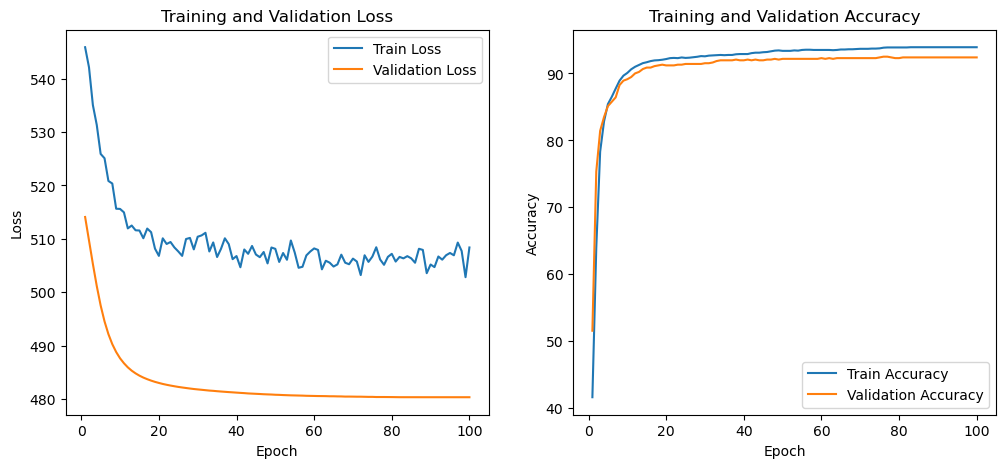

In [21]:
# Plot training/validation loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["train_acc"], label="Train Accuracy")
plt.plot(history["epoch"], history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

NN Evaluation

In [23]:
# Evaluate the model on the test set
accuracy = functions.evaluate_MLP(model, X_test_tensor, Y_test_tensor, device)
print("Test accuracy:\n", accuracy)

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(y_test, predicted_labels)
print("Classification Report:\n", cr)

Test accuracy:
 0.9239956568946797
Confusion Matrix:
 [[449 109]
 [ 24 339]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.80      0.87       558
           1       0.76      0.93      0.84       363

    accuracy                           0.86       921
   macro avg       0.85      0.87      0.85       921
weighted avg       0.87      0.86      0.86       921



### Conclusion

On this dataset, logistic regression with standardization is the best overall choice: it gets around 0.93 accuracy/F1, trains fast, and gives reliable probabilities. 

Random Forest can be a bit higher (~0.94), thanks to non-linear patterns, but it’s less interpretable and its probability scores are less reliable (you’d need to set the decision threshold carefully). 

LDA/QDA do worse because their assumptions don’t fit these features, and the MLP doesn’t help much on a small dataset without heavy tuning. 

So for simplicity and robustness, pick logistic regression; if you only care about squeezing out a tiny bit more accuracy, try Random Forest.